<a href="https://colab.research.google.com/github/Sampreetee/Bharat_Intern_Task/blob/main/Sleep_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shape: (374, 13)
Columns: ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']
Using target column: Quality of Sleep


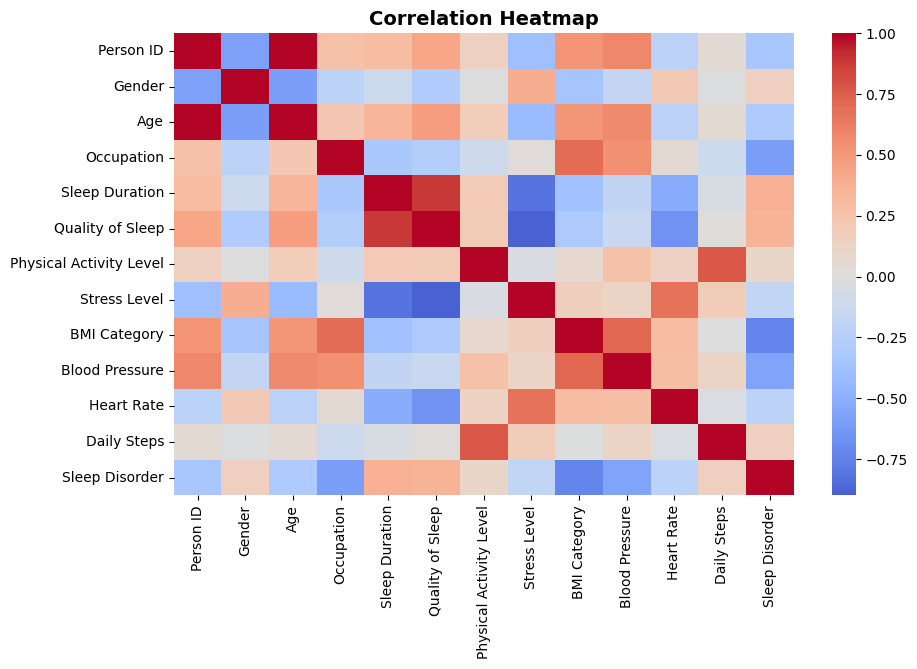


Top correlated features with sleep quality:
Stress Level               0.898752
Sleep Duration             0.883213
Heart Rate                 0.659865
Age                        0.473734
Person ID                  0.431612
Sleep Disorder             0.357477
BMI Category               0.312562
Gender                     0.291366
Occupation                 0.278071
Physical Activity Level    0.192896
Blood Pressure             0.147769
Daily Steps                0.016791
Name: Quality of Sleep, dtype: float64


/tmp/ipython-input-1732854842.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_sorted.head(top_n).values, y=corr_sorted.head(top_n).index, palette="viridis")


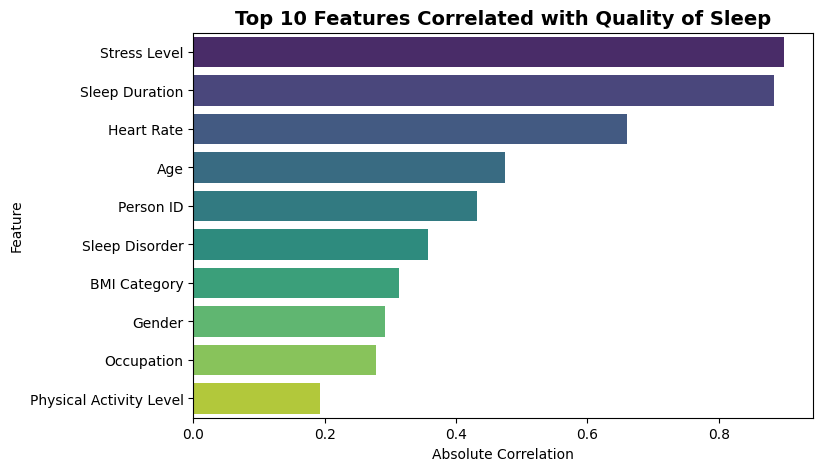

/tmp/ipython-input-1732854842.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=strong_corr.values, y=strong_corr.index, palette="magma")


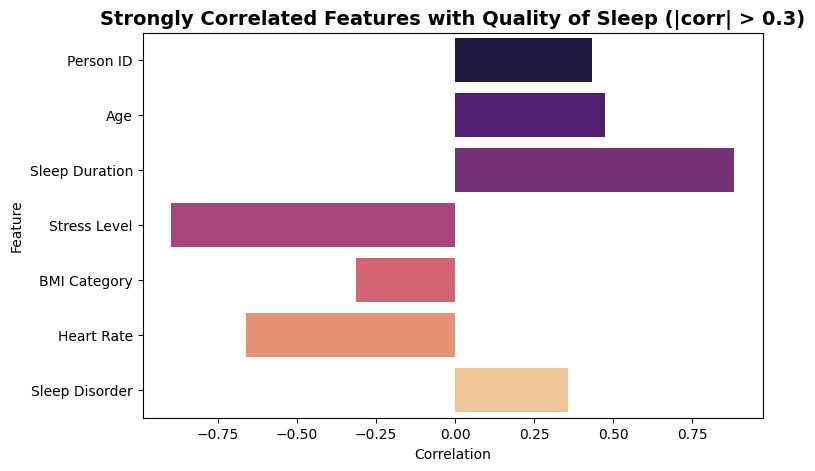


Features with strong correlation to sleep quality:
Person ID         0.431612
Age               0.473734
Sleep Duration    0.883213
Stress Level     -0.898752
BMI Category     -0.312562
Heart Rate       -0.659865
Sleep Disorder    0.357477
Name: Quality of Sleep, dtype: float64

Model Performance:
                       RMSE       MAE        R2
Linear Regression  0.215779  0.158000  0.969137
Random Forest      0.133250  0.041133  0.988231
XGBoost            0.192028  0.047456  0.975557


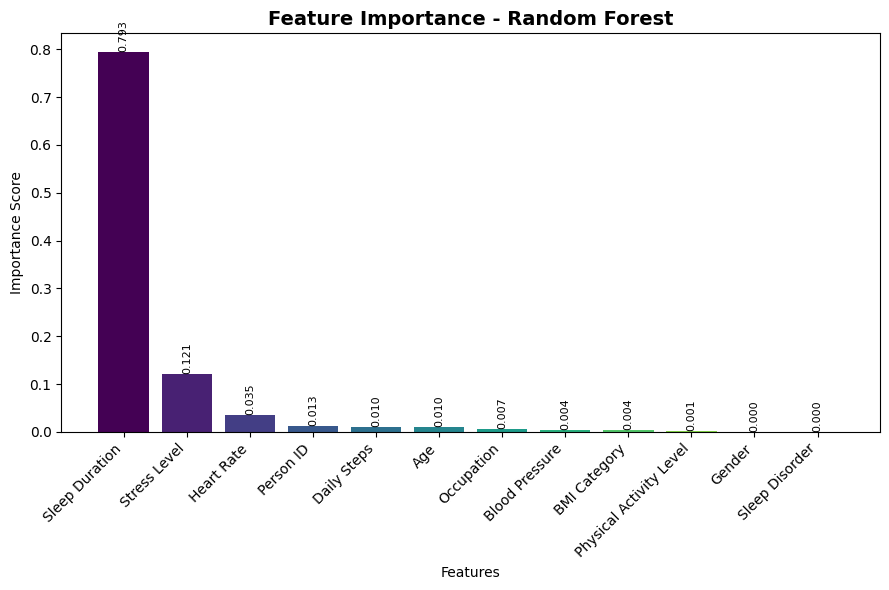

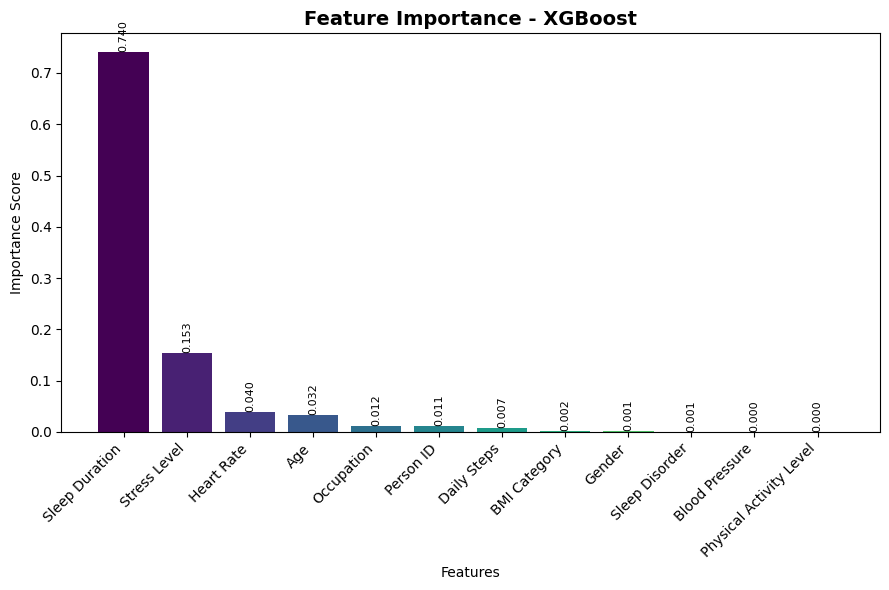

Linear Regression Prediction for example: 9.11
Random Forest Prediction for example: 9.00
XGBoost Prediction for example: 9.00


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# Step 1: Load Dataset
data = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
# Step 2: Preprocessing
# Encode categorical columns
data_encoded = data.copy()
for col in data_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])

# Detect target column automatically
possible_targets = ["Sleep_Quality", "Quality of Sleep", "sleep_quality", "quality_of_sleep"]
target_col = None
for col in data_encoded.columns:
    if col in possible_targets:
        target_col = col
        break

if target_col is None:
    raise ValueError("Could not find a target column for sleep quality. Please check column names.")

print(f"Using target column: {target_col}")
# Step 3a: Correlation Heatmap
plt.figure(figsize=(10,6))
corr = data_encoded.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap", fontsize=14, fontweight="bold")
plt.show()
# Step 3b: Top Correlated Features
corr_with_target = corr[target_col].drop(target_col)  # remove self-correlation
corr_sorted = corr_with_target.abs().sort_values(ascending=False)

print("\nTop correlated features with sleep quality:")
print(corr_sorted)

# Plot top 10 correlations
top_n = 10
plt.figure(figsize=(8,5))
sns.barplot(x=corr_sorted.head(top_n).values, y=corr_sorted.head(top_n).index, palette="viridis")
plt.title(f"Top {top_n} Features Correlated with {target_col}", fontsize=14, fontweight="bold")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.show()
# Step 3c: Highlight Strong Correlations
threshold = 0.3
strong_corr = corr_with_target[abs(corr_with_target) > threshold]

plt.figure(figsize=(8,5))
sns.barplot(x=strong_corr.values, y=strong_corr.index, palette="magma")
plt.title(f"Strongly Correlated Features with {target_col} (|corr| > {threshold})", fontsize=14, fontweight="bold")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

print("\nFeatures with strong correlation to sleep quality:")
print(strong_corr)
# Step 4: Features and Target
X = data_encoded.drop(columns=[target_col])
y = data_encoded[target_col]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Step 5: Train Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }
    trained_models[name] = model

# -----------------------------
# Step 6: Compare Results
# -----------------------------
results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)

# -----------------------------
# Step 7: Feature Importance (RF & XGBoost)
# -----------------------------
feature_names = X.columns
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))

for name in ["Random Forest", "XGBoost"]:
    model = trained_models[name]
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(9,6))
        bars = plt.bar(range(len(importances)), importances[indices], align="center", color=colors)
        plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha="right")
        plt.title(f"Feature Importance - {name}", fontsize=14, fontweight="bold")
        plt.xlabel("Features")
        plt.ylabel("Importance Score")

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.3f}", ha='center', va='bottom', fontsize=8, rotation=90)

        plt.tight_layout()
        plt.show()

# -----------------------------
# Step 8: Example Prediction
# -----------------------------
example = X_test[0].reshape(1, -1)
for name, model in trained_models.items():
    pred = model.predict(example)[0]
    print(f"{name} Prediction for example: {pred:.2f}")


Data shape: (374, 13)
Columns: ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']
Using target column: Quality of Sleep

Top correlated features with sleep quality:
Stress Level               0.898752
Sleep Duration             0.883213
Heart Rate                 0.659865
Age                        0.473734
Person ID                  0.431612
Sleep Disorder             0.357477
BMI Category               0.312562
Gender                     0.291366
Occupation                 0.278071
Physical Activity Level    0.192896
Blood Pressure             0.147769
Daily Steps                0.016791
Name: Quality of Sleep, dtype: float64

Strongly correlated features (|corr|>0.3):
Person ID         0.431612
Age               0.473734
Sleep Duration    0.883213
Stress Level     -0.898752
BMI Category     -0.312562
Heart Rate       -0.659865
Sl

/tmp/ipython-input-3696685191.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_sorted.head(10).values, y=corr_sorted.head(10).index, palette="viridis")


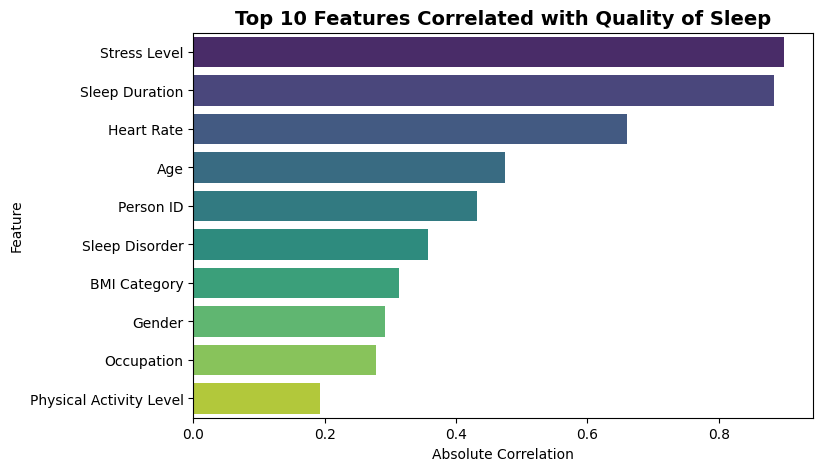

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0457025384297296, tolerance: 0.03264769874476988
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04185870051802976, tolerance: 0.03264769874476988
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03367233563568206, tolerance: 0.03259916317991634
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Con


Model Performance:
                       RMSE       MAE        R2      CV_R2
Linear Regression  1.040865  0.199646  0.281861 -15.738812
Lasso Regression   0.178415  0.126102  0.978900   0.821492
Random Forest      0.094926  0.026200  0.994027   0.758734
XGBoost            0.098036  0.015872  0.993629   0.655665


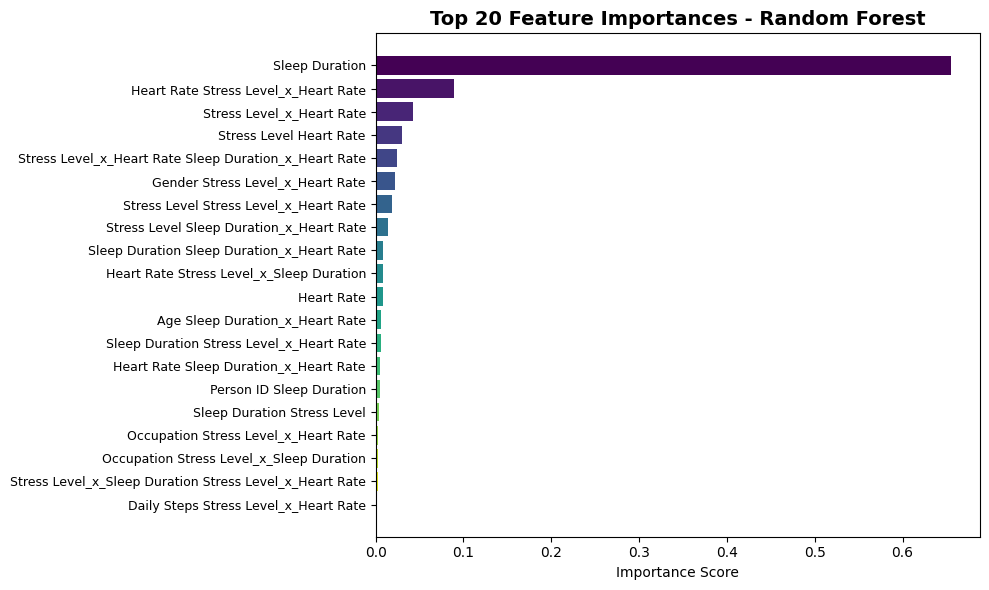

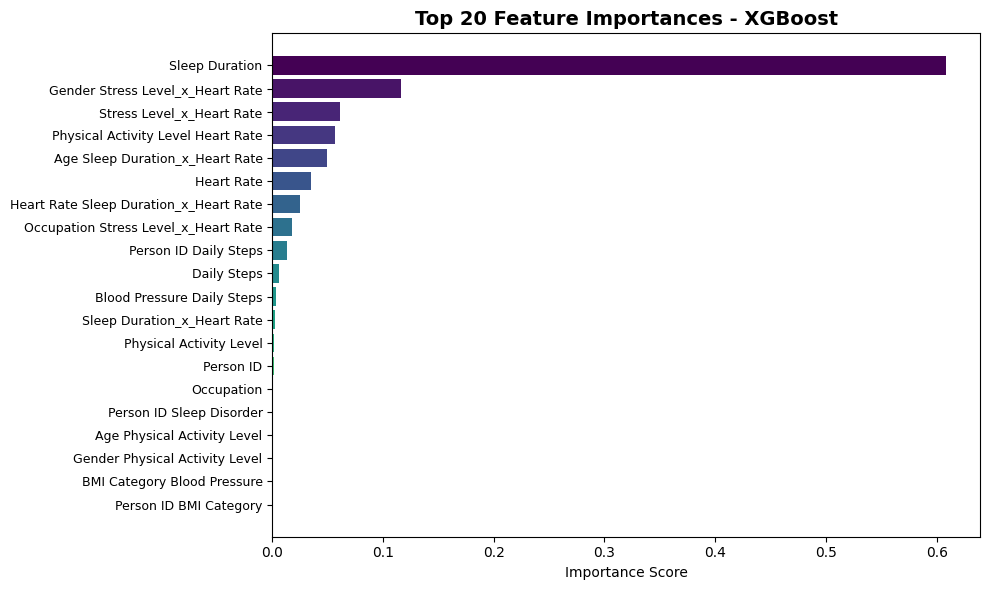

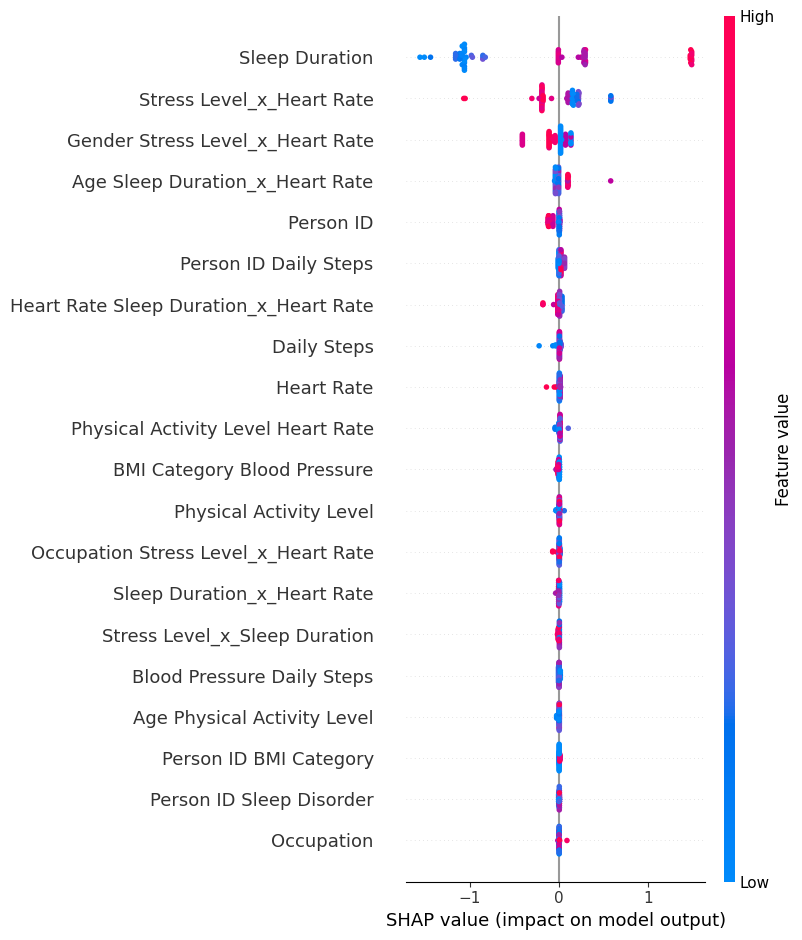

Linear Regression Prediction for example: 9.00
Lasso Regression Prediction for example: 9.08
Random Forest Prediction for example: 9.00
XGBoost Prediction for example: 9.00


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap

# -----------------------------
# Step 1: Load Dataset
# -----------------------------
data = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())

# -----------------------------
# Step 2: Preprocessing
# -----------------------------
data_encoded = data.copy()
for col in data_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])

# Detect target column
possible_targets = ["Sleep_Quality", "Quality of Sleep", "sleep_quality", "quality_of_sleep"]
target_col = None
for col in data_encoded.columns:
    if col in possible_targets:
        target_col = col
        break
if target_col is None:
    raise ValueError("❌ Could not find a target column for sleep quality.")
print(f"Using target column: {target_col}")

# -----------------------------
# Step 3: Correlations
# -----------------------------
corr = data_encoded.corr()
corr_with_target = corr[target_col].drop(target_col)
corr_sorted = corr_with_target.abs().sort_values(ascending=False)
strong_corr = corr_with_target[abs(corr_with_target) > 0.3]

print("\nTop correlated features with sleep quality:")
print(corr_sorted)
print("\nStrongly correlated features (|corr|>0.3):")
print(strong_corr)

# Optional: plot top correlations
plt.figure(figsize=(8,5))
sns.barplot(x=corr_sorted.head(10).values, y=corr_sorted.head(10).index, palette="viridis")
plt.title(f"Top 10 Features Correlated with {target_col}", fontsize=14, fontweight="bold")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.show()

# -----------------------------
# Step 4: Feature Engineering
# -----------------------------
X = data_encoded.drop(columns=[target_col])
y = data_encoded[target_col]

# Example interaction feature: combine top 3 correlated features
top_features = corr_sorted.head(3).index.tolist()
for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        new_col = f"{top_features[i]}_x_{top_features[j]}"
        X[new_col] = X[top_features[i]] * X[top_features[j]]

# Optional: Polynomial features for non-linear effects
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)

# Scale features for linear models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# -----------------------------
# Step 5: Train Models
# -----------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": LassoCV(cv=5),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Cross-validation score
    cv_score = cross_val_score(model, X_scaled, y, cv=5, scoring='r2').mean()
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "CV_R2": cv_score
    }
    trained_models[name] = model

# -----------------------------
# Step 6: Compare Results
# -----------------------------
results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)

# -----------------------------
# Step 7: Feature Importance (RF & XGBoost) - Cleaner Visualization
# -----------------------------
def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """Plots top_n feature importances for tree-based models."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]  # take top N

    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(indices)), importances[indices],
                    color=plt.cm.viridis(np.linspace(0, 1, len(indices))))
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=9)
    plt.gca().invert_yaxis()  # highest on top
    plt.title(f"Top {top_n} Feature Importances - {model_name}", fontsize=14, fontweight="bold")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# Plot for both models
for name in ["Random Forest", "XGBoost"]:
    model = trained_models[name]
    if hasattr(model, "feature_importances_"):
        plot_feature_importance(model, feature_names, name, top_n=20)

# -----------------------------
# Step 8: SHAP Interpretation (for XGBoost)
# -----------------------------
explainer = shap.Explainer(trained_models["XGBoost"])
shap_values = explainer(X_test)

# Limit to top 20 for readability
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names, max_display=20)

# -----------------------------
# Step 9: Example Prediction
# -----------------------------
example = X_test[0].reshape(1, -1)
for name, model in trained_models.items():
    pred = model.predict(example)[0]
    print(f"{name} Prediction for example: {pred:.2f}")
